
# Day 0.5: NeuralNets 101
### Benny Border <Borde206@umn.edu>, Felipe Fontinele Nunes <fonti007@umn.edu>
NB author: Benny Border








With various things taken from from Michael Coughlin(UMN), models from Nabeel Rehemtulla (Northwestern) and timm (huggingface), and many "willful" contributions I am currently forgetting  :)



Overview: Review on supervised learning, then we'll take a look at MLPs and how they can learn complex relationships, see how different imagenets work, before finally going over images+metadata tactics for transient classification



## Machine Learning, a bundle of math tricks

<img src="figures/mindmap.jpg" width=600>

tldr: machine learning is just a "grab-all" term for algorithms that find patterns in data automatically.



## Two types of learning:

- In Supervised Learning you've got labels for the data
    - metric defines the distance between predictions for the labels and true labels
    - *the labels are correct*

- Unsupervised Learning is about finding structure in the data
    - metric defines the distance between samples
    - useful for clustering, density estimation, anomaly detection


### In appleCiDeR though, we like neural networks...


### Introducing, Perceptrons:
the foundation of neural networks

<img src="figures/perceptron1.png" width=600>

<img src="figures/perceptron3.png" width=600>

## or, $$y=w^ix_i + b$$

## or,  

$$y=
\begin{bmatrix}
a_1 & a_2 & a_3 & \cdots & a_n \\
\end{bmatrix} \begin{bmatrix}
x_1 \\
x_2 \\
x_3 \\
\vdots \\
x_n \\
\end{bmatrix}
= \begin{bmatrix}
a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots + a_n x_n \\
\end{bmatrix}$$














### to get an output between 0 and 1, we put the logits through an activation function:
<img src="figures/perceptron6.png" width=600>

<img src="figures/activation_functions.png" width=600>

<img src="figures/mlp1.png" width=600>  


in terms of linear algebra:

\begin{align*}
\vec{y} =
&\begin{bmatrix}
a_1 & a_2 & a_3 & \cdots & a_n \\ 
b_1 & b_2 & b_3 & \cdots & b_n \\
c_1 & c_2 & c_3 & \cdots & c_n \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
m_1 & m_2 & m_3 & \cdots & m_n \\
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2 \\
x_3 \\
\vdots \\
x_n \\
\end{bmatrix}
=
\begin{bmatrix}
a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots + a_n x_n \\
b_1 x_1 + b_2 x_2 + b_3 x_3 + \cdots + b_n x_n \\
c_1 x_1 + c_2 x_2 + c_3 x_3 + \cdots + c_n x_n \\
\vdots \\
m_1 x_1 + m_2 x_2 + m_3 x_3 + \cdots + m_n x_n \\
\end{bmatrix}
=
\begin{bmatrix}
o_1 \\
o_2 \\
o_3 \\
\cdots \\
o_m \\
\end{bmatrix}
\end{align*}  

or, in Einstein notation:

## $y_i = W_{ij} x^j + b_i $  
logit (noun, float):  
    - The raw decimal output of a single perceptron.



<img src="figures/dnn1.png" width=600>

<img src='figures/dl5.png' width=600>  


Getting the weights is done by two passes of operations done on the model:
- The forward pass:
   - Input data is run through the model to produce outputs
    - making predictions based on INPUT data
- The backward pass:
    - Model's predictions are scrutinized and compared with truth values
    - Model weights are updated based on performance  




To update the weights during backpropagation, we start with defining what is correct and not:  
## $\widehat{y} = \begin{cases} 1 & \text{if correct} , \\ 0 & \text{otherwise.} \end{cases}$



Where $\theta$ is the **threshold**

We compare the output vector $y$ to the target/truth $t$ and we want to minimize the error

## $ E = 1/2 \cdot (t-y)^2$

To minimize the error, we need to change the weights of the inputs to get $t$ close to $y$.


Let's do this with our old friend, **gradient descent**

## $w_i = w'_i - \eta \cdot \frac{dE}{dw_i} $

Where $\eta$ is some constant that we'll call the **learning rate**

## $w_i = w'_i + \eta \cdot (t-y) \cdot\frac{dy}{dw_i} $

## $\frac{dy}{dw_i} = x_i $

so..


## $w_i = w'_i + \eta \cdot (t-y) \cdot u_i $
$\text{or,}$

## $ w_{\text{new}}  = w_{\text{old}} + \eta \cdot (t-y) \cdot u$



## Example 1: Transforming Coordinates  
To show just how good MLPs are at approximating wacky functions, lets train one to transform points from equatorial coordinates into galactic coordinates  


Galactic coords reference:

 <img src="figures/galactic.png" width=550>

 l: Galactic longitude  
 b: Galactic latitude



In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from astropy.coordinates import SkyCoord
import astropy.units as u
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from time import time
from copy import deepcopy
#from Equi2GalMLP import EquatorialToGalacticMLP
from LossFunc import GreatCircleLoss, GreatCircleLoss_no_average
from tqdm import tqdm
import time
from torch.utils.data import Dataset
import torch.nn.functional as F
import random
from dataloader import get_dataloaders
import numpy as np
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from pathlib import Path
from sklearn.metrics import auc as sklearn_auc
from plotter import plot_combined_results
from datetime import datetime as t
from train_utils import select_gpu, calculate_pr_auc, get_class_counts, calculate_val_loss



# torch.manual_seed(42)          # CPU
# torch.cuda.manual_seed(42)     # Current GPU
# torch.cuda.manual_seed_all(42) # All GPUs (if multi-GPU)

# # Set NumPy seed
# np.random.seed(42)

# # Set Python's built-in random seed
# random.seed(42)

# # Additional PyTorch settings for determinism
# torch.backends.cudnn.deterministic = True  # Uses deterministic algorithms
# torch.backends.cudnn.benchmark = False     # Disables benchmarking (for reproducibility)

/Users/sjcallis/anaconda3/envs/ztfss25/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



lets start by making a function to generate data:


note that we don't want to just hand our model the ra/dec in degrees, so we normalize the coordinates to be between -1 and 1

In [2]:
def generate_data(num_samples=10000):
        """Generate training data with RA in degrees (0-360) and Dec in degrees (-90 to 90)"""
        ra = np.random.uniform(0, 360, num_samples)
        dec = np.random.uniform(-90, 90, num_samples)
        
        # Convert to galactic coordinates using astropy
        equatorial = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
        galactic = equatorial.galactic
        
        # Extract l (0-360) and b (-90 to 90) in degrees
        l = galactic.l.deg
        b = galactic.b.deg
        
        # Normalize all values to [-1, 1] range
        inputs = np.column_stack((ra / 180 - 1, dec / 90))  # RA: [0,360] -> [-1,1], Dec: [-90,90] -> [-1,1]
        answers = np.column_stack((l / 180 - 1, b / 90))     # l: [0,360] -> [-1,1], b: [-90,90] -> [-1,1]
        
        
        return inputs, answers 



Now, lets throw together a function that can tell us "what % of samples fall within X degrees of the correct answer" 

In [17]:
import numpy as np
import torch

def get_cutoff_acc(model, X, y, cutoff_deg=1):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        loss = GreatCircleLoss(outputs, y).item()
        
        # Convert predictions and true values to degrees
        true_l, true_b = y[:, 0].cpu().numpy(), y[:, 1].cpu().numpy()
        pred_l, pred_b = outputs[:, 0].cpu().numpy(), outputs[:, 1].cpu().numpy()
        
        true_l = (true_l + 1) * 180  # [-1,1] -> [0,360]
        true_b = true_b * 90         # [-1,1] -> [-90,90]
        pred_l = (pred_l + 1) * 180
        pred_b = pred_b * 90
        
        # Convert degrees to radians for great circle distance calculation
        true_l_rad = np.radians(true_l)
        true_b_rad = np.radians(true_b)
        pred_l_rad = np.radians(pred_l)
        pred_b_rad = np.radians(pred_b)
        
        # Calculate great circle distance for each point
        # Haversine formula
        dlon = pred_l_rad - true_l_rad
        dlat = pred_b_rad - true_b_rad
        a = np.sin(dlat/2)**2 + np.cos(true_b_rad) * np.cos(pred_b_rad) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        great_circle_dist_deg = np.degrees(c)
        
        # Calculate accuracy based on great circle distance
        correct = np.sum(great_circle_dist_deg < cutoff_deg)
        total = len(true_l)
        acc = correct / total
        
        # Also compute individual accuracies for l and b (optional)
        l_diff = np.abs(true_l - pred_l)
        l_diff = np.minimum(l_diff, 360 - l_diff)
        b_diff = np.abs(true_b - pred_b)
        
        correct_l = np.sum(l_diff < cutoff_deg)
        correct_b = np.sum(b_diff < cutoff_deg)
        
        acc_l = correct_l / total
        acc_b = correct_b / total
        
    return loss, acc_l, acc_b, acc




## And lets also make a plotting function real quick

def plot_training_history(training_history, cutoff_deg, save_path):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Loss plot
        ax1.plot(training_history['train_loss'], label='Train Loss')
        ax1.plot(training_history['val_loss'], label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        
        # Accuracy plot
        ax2.plot(training_history['train_acc'], label='Train Accuracy')
        ax2.plot(training_history['val_acc'], label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title(f'Accuracy (Cutoff = {cutoff_deg}°)')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        fig.savefig(save_path)

### Model Architecture:

In [22]:
'''
There are tons of different options for how to structure these, but we'll do a simple one for this example:
'''

class EquatorialToGalacticMLP(nn.Module):
    """An MLP for converting equatorial to galactic coordinates.
    
    Takes equatorial coordinates (right ascension and declination) as input
    and outputs the corresponding galactic coordinates (l, b) in normalized form.
    
    The Tanh output activation assumes coordinates are normalized to [-1, 1].
    
    Args:
        input_size (int, optional): Number of input features. Defaults to 2 for (ra, dec).
        hidden_size (int, optional): Number of neurons in hidden layers. Defaults to 128.


    Example:
        >>> model = EquatorialToGalacticMLP()
        >>> equatorial_coords = torch.tensor([[0.5, -0.2]])  # normalized (ra, dec)
        >>> galactic_coords = model(equatorial_coords)  # predicted (l, b)
    """
    def __init__(self, input_size=2, output_size=2, hidden_size=64):
        super(EquatorialToGalacticMLP, self).__init__()
        
        # main body blocks
        self.block1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )

        self.block2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        self.block3 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        
        # output block 
        self.end = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Tanh()
        )

    
    def forward(self, x):
        block1_feats = self.block1(x)
        
        block2_feats = self.block2(block1_feats)

        block3_feats = self.block3(block2_feats)

        out = self.end(block3_feats)
    
        return out



### Training Logistics:

For reasons that will soon become evident, we are going to split our data into two sets, one training dataset(80%-ish of the total dataset), and one validation set(whatever is leftover).

The training dataset will then be further segmented into equal sized "batches" of samples. This is because 

Training is done in stages known as "Epochs" (pronounced: eh·puhks). During each epoch, every sample in the training set is run through the once.(unless you configure it to do otherwise, known as oversampling and undersampling)




Here's a bit of pseudocode of how the script is usually structured
- for epoch in epochs:
    - training set is broken into equally sized "batches" of samples to be handled in succession
    - for batch in batches:
        - loss function will take the average loss "score" of the batch
        - loss "score" used to calculate the gradients for the weights
        - weights are updated by an optimizer
        - next batch...

    - if (score hasn't improved in X epochs):
        - End training
    - else:  
        - next epoch...  


### Overtraining: The Bane of Machine Learning  
Simply put, overtraining is when a model learns features that don't generalize. These are patterns that *only* exist in the dataset it was trained on, things you wouldn't be able to find in any new data(even if it's from the same source).  
<img src="figures/overfitted.png" width=800>  


Because of this, we track the performance of our model throughout training on a separate "validation" dataset that the model hasn't "seen" before, saving the running best performing weights to a file as we go along. This validation score is what we track for early stopping.





### That isn't super informative though, because we're also worried about **where** it's right or wrong

so lets plot how many degrees off our models predictions are as a function of position:

In [23]:
# define which device(GPU or CPU) we want to use
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device:{device}')
# if you have multiple GPUs, you can select which one to use by adding the index to the end, ie: "cuda:0" or "cuda:1"

num_epochs = 50
learning_rate = 1e-3
batch_size = 256
cutoff_deg = 1
patience = 10
hidden_size = 256

model = EquatorialToGalacticMLP(hidden_size=hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


inputs, answers = generate_data(num_samples=100000)
inputs_train, inputs_val, answers_train, answers_val = train_test_split(inputs, answers, test_size=0.2, random_state=22)


# Convert to PyTorch tensors
inputs_train = torch.FloatTensor(inputs_train).to(device)
answers_train = torch.FloatTensor(answers_train).to(device)
inputs_val = torch.FloatTensor(inputs_val).to(device)
answers_val = torch.FloatTensor(answers_val).to(device)


training_history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'epoch_times': []
        }
# Training loop
try:
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()

        permutation = torch.randperm(inputs_train.size()[0])
        
        train_total = 0
        train_correct_l = 0
        train_correct_b = 0
        epoch_loss = 0
        train_correct = 0
        best_val_loss = float('inf')
        epochs_no_improve = 0


        # Iterate through batches using the DataLoader
        for i in tqdm(range(0, inputs_train.size()[0], batch_size), unit='batch', desc='Training', leave=False):

            indices = permutation[i:i+batch_size]
            batch_X, batch_y = inputs_train[indices], answers_train[indices]
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = GreatCircleLoss(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

            
            # Calculate accuracy for this batch
            with torch.no_grad():
                true_l, true_b = batch_y[:, 0].cpu().numpy(), batch_y[:, 1].cpu().numpy()
                pred_l, pred_b = outputs[:, 0].cpu().numpy(), outputs[:, 1].cpu().numpy()
                
                # Convert to radians
                true_l = (true_l + 1) * np.pi  # [-1,1] -> [0,2pi]
                true_b = true_b * np.pi/4      # [-1,1] -> [-pi/4,pi/4]
                pred_l = (pred_l + 1) * np.pi
                pred_b = pred_b * np.pi/4
                
                
                # Haversine formula for great circle distance
                dlon = pred_l - true_l
                dlat = pred_b - true_b
                a = np.sin(dlat/2)**2 + np.cos(true_b) * np.cos(pred_b) * np.sin(dlon/2)**2
                c = 2 * np.arcsin(np.sqrt(a))
                great_circle_dist_deg = np.degrees(c)
                
                # Count correct predictions (within cutoff_deg)
                train_correct += np.sum(great_circle_dist_deg < cutoff_deg)
                train_total += len(true_l)



        train_loss = epoch_loss/(train_total / batch_size) 
        train_acc_l = train_correct_l / train_total
        train_acc_b = train_correct_b / train_total
        train_acc = train_correct / train_total

        
        # Validation
        # val_loss, val_l_diff, val_b_diff = get_acc(model, val_loader, device=device)
        val_loss, val_acc_l, val_acc_b, val_acc = get_cutoff_acc(model, inputs_val, answers_val, cutoff_deg=cutoff_deg)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Update training history
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_acc'].append(val_acc)
        training_history['epoch_times'].append(time.time() - epoch_start)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
            torch.save(best_model, f"best_coords_model.pth")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
        

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | '
              f'Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%} | '
              f'l Acc: {val_acc_l:.2%}, b Acc: {val_acc_b:.2%}')
    model.load_state_dict(torch.load(f"best_coords_model.pth"))
    #plot_training_history(training_history, cutoff_deg, save_path)
                    
except KeyboardInterrupt:
    print(f'Early stopping at epoch {epoch+1}')
    model.load_state_dict(torch.load(f"best_coords_model.pth"))
    #plot_training_history(training_history, cutoff_deg, save_path)


Using device:cpu


Epoch 1/50: Train Loss: 11.3812, Val Loss: 5.5039 | Train Acc: 7.12%, Val Acc: 8.09% | l Acc: 19.75%, b Acc: 45.81%


Epoch 2/50: Train Loss: 4.1250, Val Loss: 3.2325 | Train Acc: 19.11%, Val Acc: 9.56% | l Acc: 29.38%, b Acc: 35.60%


Epoch 3/50: Train Loss: 3.0798, Val Loss: 3.3815 | Train Acc: 26.85%, Val Acc: 7.96% | l Acc: 16.27%, b Acc: 39.64%


Epoch 4/50: Train Loss: 2.6144, Val Loss: 2.3061 | Train Acc: 30.65%, Val Acc: 21.41% | l Acc: 25.34%, b Acc: 82.26%


Epoch 5/50: Train Loss: 2.2512, Val Loss: 2.5273 | Train Acc: 39.14%, Val Acc: 20.95% | l Acc: 24.64%, b Acc: 64.73%


Epoch 6/50: Train Loss: 1.9949, Val Loss: 1.8551 | Train Acc: 40.37%, Val Acc: 50.21% | l Acc: 47.51%, b Acc: 93.12%


Epoch 7/50: Train Loss: 1.9698, Val Loss: 1.6912 | Train Acc: 44.77%, Val Acc: 41.47% | l Acc: 56.59%, b Acc: 60.34%


Epoch 8/50: Train Loss: 1.8310, Val Loss: 2.3570 | Train Acc: 51.57%, Val Acc: 33.03% | l Acc: 33.13%, b Acc: 55.75%


Epoch 9/50: Train Loss: 1.7526, Val Loss: 1.7693 | Train Acc: 46.33%, Val Acc: 39.90% | l Acc: 37.98%, b Acc: 88.43%


Epoch 10/50: Train Loss: 1.5809, Val Loss: 1.4827 | Train Acc: 51.20%, Val Acc: 53.58% | l Acc: 53.71%, b Acc: 92.67%


Epoch 11/50: Train Loss: 1.5091, Val Loss: 1.6994 | Train Acc: 58.84%, Val Acc: 54.12% | l Acc: 69.56%, b Acc: 73.97%


Epoch 12/50: Train Loss: 1.5055, Val Loss: 1.6243 | Train Acc: 54.04%, Val Acc: 45.33% | l Acc: 58.65%, b Acc: 63.71%


Epoch 13/50: Train Loss: 1.2869, Val Loss: 1.7502 | Train Acc: 62.91%, Val Acc: 20.31% | l Acc: 53.90%, b Acc: 43.06%


Epoch 14/50: Train Loss: 1.3647, Val Loss: 1.1422 | Train Acc: 63.79%, Val Acc: 63.81% | l Acc: 68.55%, b Acc: 90.36%


Epoch 15/50: Train Loss: 1.3312, Val Loss: 1.3570 | Train Acc: 59.62%, Val Acc: 44.75% | l Acc: 55.29%, b Acc: 76.42%


Epoch 16/50: Train Loss: 1.2178, Val Loss: 1.5271 | Train Acc: 62.40%, Val Acc: 31.64% | l Acc: 78.88%, b Acc: 46.68%


Epoch 17/50: Train Loss: 1.4227, Val Loss: 2.0564 | Train Acc: 64.68%, Val Acc: 47.09% | l Acc: 58.64%, b Acc: 75.37%


Epoch 18/50: Train Loss: 1.2863, Val Loss: 1.2837 | Train Acc: 67.91%, Val Acc: 56.53% | l Acc: 56.70%, b Acc: 93.55%


Epoch 19/50: Train Loss: 0.6785, Val Loss: 0.6957 | Train Acc: 90.81%, Val Acc: 89.46% | l Acc: 90.98%, b Acc: 97.00%


Epoch 20/50: Train Loss: 0.6831, Val Loss: 0.5917 | Train Acc: 91.45%, Val Acc: 94.10% | l Acc: 91.04%, b Acc: 98.75%


Epoch 21/50: Train Loss: 0.7307, Val Loss: 0.7360 | Train Acc: 91.10%, Val Acc: 94.12% | l Acc: 91.67%, b Acc: 97.97%


Epoch 22/50: Train Loss: 0.9335, Val Loss: 0.8265 | Train Acc: 89.82%, Val Acc: 87.17% | l Acc: 88.93%, b Acc: 95.49%


Epoch 23/50: Train Loss: 0.7656, Val Loss: 0.7870 | Train Acc: 91.55%, Val Acc: 89.09% | l Acc: 91.31%, b Acc: 94.08%


Epoch 24/50: Train Loss: 0.6927, Val Loss: 0.9726 | Train Acc: 89.04%, Val Acc: 72.48% | l Acc: 69.05%, b Acc: 95.69%


Epoch 25/50: Train Loss: 0.4493, Val Loss: 0.4088 | Train Acc: 94.52%, Val Acc: 96.91% | l Acc: 94.49%, b Acc: 98.71%


Epoch 26/50: Train Loss: 0.4523, Val Loss: 0.5305 | Train Acc: 94.85%, Val Acc: 96.38% | l Acc: 94.14%, b Acc: 98.49%


Epoch 27/50: Train Loss: 0.4450, Val Loss: 0.4860 | Train Acc: 95.25%, Val Acc: 96.59% | l Acc: 94.16%, b Acc: 98.86%


Epoch 28/50: Train Loss: 0.4419, Val Loss: 0.4576 | Train Acc: 95.38%, Val Acc: 96.99% | l Acc: 94.92%, b Acc: 99.15%


Epoch 29/50: Train Loss: 0.4358, Val Loss: 0.5398 | Train Acc: 95.44%, Val Acc: 96.73% | l Acc: 94.48%, b Acc: 98.80%


Epoch 30/50: Train Loss: 0.3718, Val Loss: 0.4034 | Train Acc: 95.85%, Val Acc: 96.79% | l Acc: 95.16%, b Acc: 98.66%


Epoch 31/50: Train Loss: 0.3705, Val Loss: 0.3456 | Train Acc: 95.79%, Val Acc: 97.24% | l Acc: 95.78%, b Acc: 98.91%


Epoch 32/50: Train Loss: 0.3434, Val Loss: 0.3934 | Train Acc: 96.25%, Val Acc: 96.99% | l Acc: 95.26%, b Acc: 98.84%


Epoch 33/50: Train Loss: 0.3470, Val Loss: 0.3542 | Train Acc: 96.36%, Val Acc: 97.42% | l Acc: 95.86%, b Acc: 98.92%


Epoch 34/50: Train Loss: 0.3204, Val Loss: 0.3257 | Train Acc: 96.48%, Val Acc: 97.21% | l Acc: 95.38%, b Acc: 98.85%


Epoch 35/50: Train Loss: 0.3178, Val Loss: 0.3139 | Train Acc: 96.41%, Val Acc: 97.45% | l Acc: 95.83%, b Acc: 99.08%


Epoch 36/50: Train Loss: 0.3092, Val Loss: 0.2908 | Train Acc: 96.50%, Val Acc: 97.46% | l Acc: 95.73%, b Acc: 99.19%


Epoch 37/50: Train Loss: 0.3196, Val Loss: 0.3614 | Train Acc: 96.46%, Val Acc: 97.28% | l Acc: 95.91%, b Acc: 99.11%


Epoch 38/50: Train Loss: 0.3316, Val Loss: 0.3472 | Train Acc: 96.24%, Val Acc: 97.38% | l Acc: 95.86%, b Acc: 99.18%


Epoch 39/50: Train Loss: 0.2998, Val Loss: 0.3624 | Train Acc: 96.56%, Val Acc: 97.34% | l Acc: 95.53%, b Acc: 99.20%


Epoch 40/50: Train Loss: 0.3085, Val Loss: 0.3169 | Train Acc: 96.64%, Val Acc: 97.49% | l Acc: 96.04%, b Acc: 99.21%


Epoch 41/50: Train Loss: 0.2701, Val Loss: 0.2750 | Train Acc: 96.90%, Val Acc: 97.62% | l Acc: 96.21%, b Acc: 99.31%


Epoch 42/50: Train Loss: 0.2698, Val Loss: 0.2544 | Train Acc: 96.91%, Val Acc: 97.61% | l Acc: 96.31%, b Acc: 99.27%


Epoch 43/50: Train Loss: 0.2774, Val Loss: 0.3477 | Train Acc: 96.76%, Val Acc: 97.42% | l Acc: 96.00%, b Acc: 99.09%


Epoch 44/50: Train Loss: 0.2714, Val Loss: 0.3028 | Train Acc: 96.79%, Val Acc: 97.54% | l Acc: 96.33%, b Acc: 99.31%


Epoch 45/50: Train Loss: 0.2763, Val Loss: 0.2817 | Train Acc: 96.67%, Val Acc: 97.19% | l Acc: 95.67%, b Acc: 99.22%


Epoch 46/50: Train Loss: 0.2804, Val Loss: 0.3118 | Train Acc: 96.59%, Val Acc: 97.28% | l Acc: 95.90%, b Acc: 99.22%


Epoch 47/50: Train Loss: 0.2723, Val Loss: 0.2810 | Train Acc: 96.64%, Val Acc: 97.39% | l Acc: 96.06%, b Acc: 99.34%


Epoch 48/50: Train Loss: 0.2913, Val Loss: 0.3234 | Train Acc: 96.55%, Val Acc: 97.18% | l Acc: 95.88%, b Acc: 99.23%


Epoch 49/50: Train Loss: 0.2899, Val Loss: 0.3099 | Train Acc: 96.43%, Val Acc: 97.28% | l Acc: 96.00%, b Acc: 99.27%


Epoch 50/50: Train Loss: 0.2976, Val Loss: 0.2921 | Train Acc: 96.61%, Val Acc: 97.36% | l Acc: 96.10%, b Acc: 99.34%


/var/folders/7_/30253fds1sj6461h2g9vqhbc0015zk/T/ipykernel_6774/310913158.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_coord

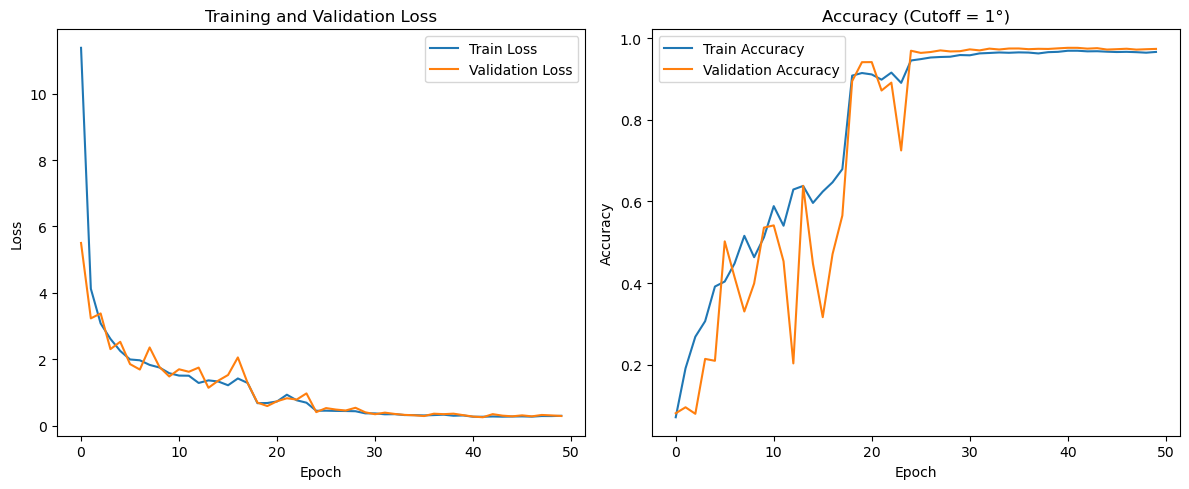

In [24]:
save_path = os.path.join('skylar_output', 'block3_training.png')
plot_training_history(training_history, cutoff_deg, save_path)

/var/folders/7_/30253fds1sj6461h2g9vqhbc0015zk/T/ipykernel_6774/47543564.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_coords_

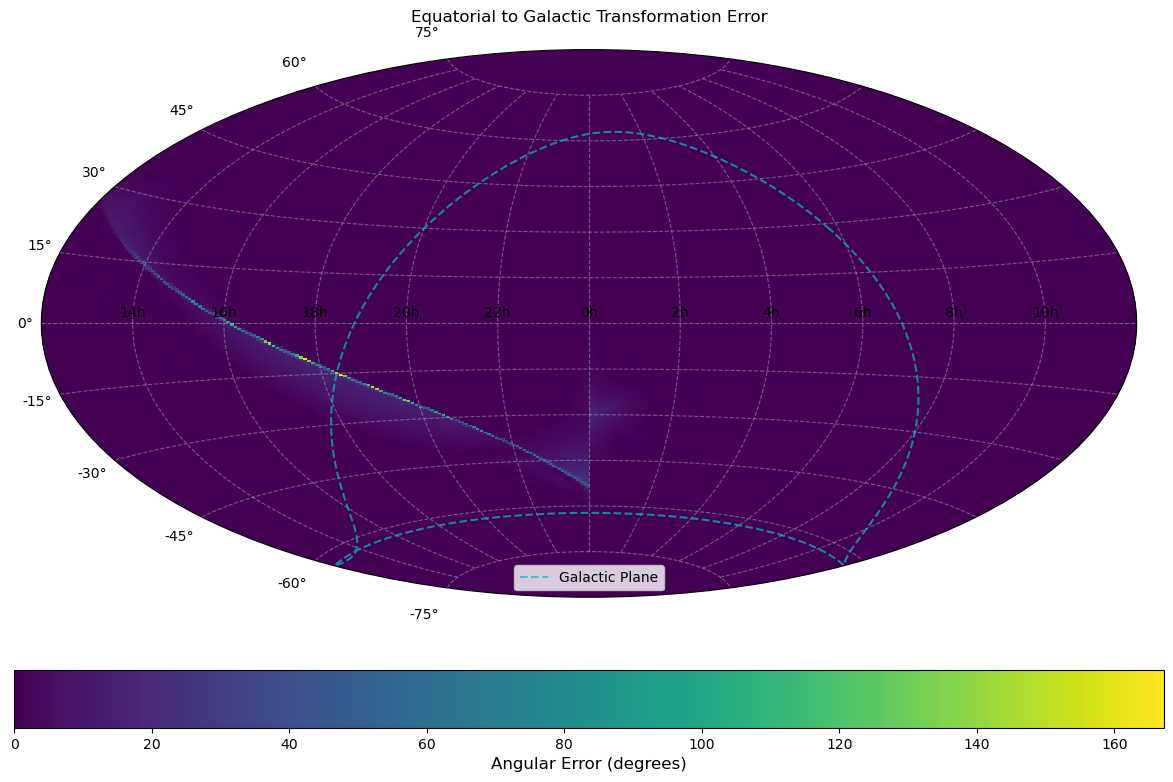

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

def generate_aitoff_plot(model, resolution=300):
    """Generate an Aitoff projection plot showing loss across the sky"""
    # Create grid of RA/Dec values
    ra_values = np.linspace(-180, 180, resolution)  # Aitoff uses -180 to 180
    dec_values = np.linspace(-90, 90, resolution)
    ra_grid, dec_grid = np.meshgrid(ra_values, dec_values)
    
    # Initialize loss grid
    loss_grid = np.zeros((resolution, resolution))
    
    model.eval()
    
    with torch.no_grad():
        # Flatten the grid and process all points
        all_ra = ra_grid.ravel()
        all_dec = dec_grid.ravel()

        
        # Prepare normalized inputs (convert RA to 0-360 for astropy)
        inputs = np.column_stack(((all_ra % 360) / 180 - 1, 
                         all_dec / 90))
        inputs = torch.FloatTensor(inputs).to(device)

        
        # Get true galactic coordinates
        equatorial = SkyCoord(ra=(all_ra % 360)*u.deg, 
                     dec=all_dec*u.deg, 
                     frame='icrs')
        galactic = equatorial.galactic
        l_true = galactic.l.deg
        b_true = galactic.b.deg


        
        # Normalize answers
        answers = np.column_stack(((l_true / 180 - 1), 
                                (b_true / 90)))
        answers = torch.FloatTensor(answers).to(device)
        



        # Calculate loss for all points
        outputs = model(inputs)
        batch_loss = GreatCircleLoss_no_average(outputs, answers)
        #batch_loss = F.mse_loss(outputs, answers, reduction='none').mean(dim=1)




        loss_deg = batch_loss.cpu().numpy()  # Convert to degrees
        # Reshape back to grid
        loss_grid = loss_deg.reshape(resolution, resolution)
    
    # Create Aitoff projection plot
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(111, projection='aitoff')
    
    # Plot the heatmap
    im = ax.pcolormesh(np.radians(ra_grid), np.radians(dec_grid), loss_grid,
                     cmap='viridis', shading='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im, orientation='horizontal', pad=0.1)
    cbar.set_label('Angular Error (degrees)', fontsize=12)
    
    # Add grid and labels
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xticklabels(['14h', '16h', '18h', '20h', '22h', '0h', '2h', '4h', '6h', '8h', '10h'])
    ax.set_title('Equatorial to Galactic Transformation Error', pad=20)
    
    # Add galactic plane
    galactic_l = np.linspace(-180, 180, 1000)
    galactic_b = np.zeros(1000)
    galactic_coords = SkyCoord(l=galactic_l*u.deg, b=galactic_b*u.deg, frame='galactic')
    equatorial_coords = galactic_coords.icrs
    ra_plane = (equatorial_coords.ra.deg + 180) % 360 - 180  # Convert to -180 to 180 range
    ax.plot(np.radians(ra_plane), np.radians(equatorial_coords.dec.deg), 
           'c--', linewidth=1.5, alpha=0.7, label='Galactic Plane')
    
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.savefig('./skylar_output/globe_circleloss.png', dpi=300, bbox_inches='tight')
    plt.show()

model.load_state_dict(torch.load(f"best_coords_model.pth"))
generate_aitoff_plot(model)

### 1a:
#### Try  changing the batch_loss in the error plotting function to the commented out loss function  
Hopefully, it should be easy to see the difference are between the two

In this case, we've exploited our own understanding of geometry to use a Loss function that perfectly represents the "goodness" for our model. The Great Circle distance between the predicted and true points on the sphere. 

This is **rarely** the case in practice, so most people will try a few different loss functions out and use whichever maches their chosen accuracy function the most. Here are the two most popular ones for classifications:


 
- Binary Cross Entropy Loss
    - For if a single sample can be in more than one class at a time
    - Each class gets its own independent "yes or no"
- Cross Entropy Loss
    - For mutually exclusive classifications 
    - for if you "know" the object belongs to *exactly* one class out of however many classes 


**MSE loss:**

<img src="skylar_output/globe_mseloss.png" width="500">

**Circle loss:**

<img src="skylar_output/globe_circleloss.png" width="500">

### 1b: 
#### Tinker!! do short runs, watching how quickly the model improves while changing one hyperparameter at a time and try adding a 3rd body block to your model and compare to before. Does it improve? 
(hint: when adding another block, remember to plug it into your forward pass)

**Base Model per Benny**

<img src="skylar_output/base_training.png" width="1000">

**One more Block**

<img src="skylar_output/block3_training.png" width="1000">


### 1c:
#### Try adding some residual connections to your model:
<img src="figures/models.jpg" width=600>

### 1d:
#### Make it a Densenet!!

*your notes here*

# Transferred learning:

When training any neuralnet, the most important resource is time. Because of this, instead of training their models from scratch every single time, it is often helpful to load in pretrained models(usually from [huggingface](https://huggingface.co/)) for the bulkier parts of a model and fine tune them to your own problem. 

It may not seem like a model trained to distinguish a moped from a space shuttle would be very good at detecting transients, but you'll see how it makes a difference.

# Example:
When looking for extragalactic transients, an important type of object to filter out are [Cataclysmic variable stars](https://en.wikipedia.org/wiki/Cataclysmic_variable_star). While these events usually aren't bright enough to be visible outside their respective galaxies, the ones in our own galaxy are more than bright enough to show up in surveys. Because of this and other reasons, many surveys(including [BTS](https://sites.astro.caltech.edu/ztf/bts/bts.php)) will avoid the galactic plane all together.  
 <img src="figures/BTSmap.png" width=685>  
But, since this doesn't cut out all of them, lets train a neuralnet to take the coordinates of an object and give us the probability of that object being a cataclysmic variable.    

ZTF CV's(cataclysmic variables) in galactic coordinates:  
  
<img src="figures/gal_aitoff_plot.png" width=750>

In [6]:


def train(config):
     

    NPY_DIR = config['npy_dir']
    # if config["gpu"] in [1, 0]:
    #     DEVICE= f"cuda:{config['gpu']}"
    # else:
    #     DEVICE = select_gpu()
    DEVICE = "cuda"
    
    print(f"Using device:{DEVICE}")
    BATCH_SIZE = config['batch_size']
    # LR = 0.0006777718906668259  
    LR = config['learning_rate']
    EPOCHS = config['epochs']
    PATIENCE =  config['patience']


    for run in range(int(1)):
        # print("Run ID:", wandb.run.id)
        
        # h = random.randint(100, 190)
        # loader_seed = h + (run*9)
        
        seed = config['seed']
        loader_seed=config['loader_seed']
        # print(f'using loader seed:{loader_seed}')
        # Python and numpy
        random.seed(seed)
        np.random.seed(seed)
        
        # PyTorch
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
        
        # Configure PyTorch for deterministic behavior
        torch.backends.cudnn.deterministic = True  # This makes CUDA operations deterministic
        torch.backends.cudnn.benchmark = False     # Should be False for reproducibility
        

        

        #============================================================
        #    Initialize model and optimize tower parameters
        # (this is where it's a bit like taming a pack of dragons)
        #============================================================

        model = config['model']
        optimizer = config['optimizer']   
        scheduler = config['scheduler']



        # Initialize data loaders'
        print("Loading data...")
        train_loader, val_loader, test_loader, classes = get_dataloaders(config)
        print("Finished loading data...")


        # class_counts = get_class_counts(train_loader,config)
        # train_weights = torch.tensor([
                        
        #                 30000/(int(count)**(1))                  
        #                 for idx, count in enumerate(class_counts)
        #             ], device=DEVICE, dtype=torch.float32)

        # criterion = nn.CrossEntropyLoss(weight=train_weights, label_smoothing=0.1)
        # criterion = nn.CrossEntropyLoss( label_smoothing=0.1)
        criterion = nn.BCELoss( )


        # assign class weights 
        

        #============================================================
        # Main Training Loop
        #============================================================

        best_pr_auc = 0
        best_val_loss = 10
        epochs_no_improve = 0

        try:
            im_fuckin_around = True
            for epoch in range(EPOCHS):
                model.train()
                train_loss = 0.0
                # train_loader.dataset.new_epoch()

                for batch in tqdm(train_loader, unit='batch', desc='Training', leave=False):
                    metadata = batch['metadata'].to(DEVICE)
                    image = batch['image'].to(DEVICE)
                    target = batch['target'].to(DEVICE)

                    optimizer.zero_grad()

                    outputs = model(metadata, image=image)
                    # target = torch.argmax(target, dim=1)  # Converts [batch, classes] → [batch]

                    loss = criterion(outputs, target)

                    loss.backward()

                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=config['max_norm'])
                    optimizer.step()
                    train_loss += loss.item()

            
                val_pr_auc_mean, val_pr_aucs, _, _ = calculate_pr_auc(val_loader, model,  DEVICE, config)
                val_loss = calculate_val_loss(val_loader, model, criterion, DEVICE) 

                train_loss /= len(train_loader)

                if config['scheduler'] == 'cosine_annealing':
                    scheduler.step()
                if config['scheduler'] == 'reduce_on_plateau':
                    # scheduler.step(val_loss)
                    scheduler.step(1-val_pr_auc_mean)



                if val_pr_auc_mean > best_pr_auc:
                # if best_val_loss > val_loss:
                    print(val_pr_auc_mean)
                    best_pr_auc = val_pr_auc_mean
                    best_val_loss=val_loss
                    epochs_no_improve = 0
                    torch.save(model.state_dict(), f"{config['savepath']}.pth")
                    
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve == PATIENCE:
                        print(f"Early stopping at epoch {epoch+1}")
                        break



                
                pr_auc_str = "|".join([f"{name}:{auc:.3f}" for name, auc in zip(config['class_names'], val_pr_aucs)])
                print(f"Epoch {epoch+1}/{EPOCHS}|"
                    f"Train Loss:{train_loss:.4f}|"
                    f"Val loss:{val_loss:.3f}|"
                    f"Macro mean AUPRC:{val_pr_auc_mean:.4f}|"
                    f"Class AUPRCs:{pr_auc_str}")
            print(f'best loss:{best_val_loss}')
            # Evaluation
            random_stats = random_baseline_pr_auc(test_loader, n_trials=1000)
            print(f"Random Baseline PR-AUCs (mean ± std):")
            for i, class_name in enumerate(config['classes']):
                print(f"{class_name}: {random_stats['mean'][i]:.3f} ± {random_stats['std'][i]:.3f}")
            

            # Plot and save results
            model.load_state_dict(torch.load(f"{config['savepath']}.pth"))
            pr_auc_mean, pr_aucs, plt = plot_combined_results(test_loader, model, DEVICE)



        except KeyboardInterrupt:
            print(f'best loss:{best_val_loss}')
            # Evaluation
            random_stats = random_baseline_pr_auc(test_loader, n_trials=1000)
            print(f"Random Baseline PR-AUCs (mean ± std):")
            for i, class_name in enumerate(config['classes']):
                print(f"{class_name}: {random_stats['mean'][i]:.3f} ± {random_stats['std'][i]:.3f}")
            

            # Plot and save results
            model.load_state_dict(torch.load(f"{config['savepath']}.pth"))
            pr_auc_mean, pr_aucs, plt = plot_combined_results(test_loader, model, DEVICE)








def random_baseline_pr_auc( loader, config, n_trials=1000):
    all_targets = []
    for batch in loader:
        targets = batch['target']  # Directly use the target tensor

        # Convert one-hot to class indices if needed
        if targets.dim() == 2:
            targets = torch.argmax(targets, dim=1)

        all_targets.append(targets.cpu().numpy())
    targets = np.concatenate(all_targets)
    


    num_classes = len(config['classes']) 
    trial_pr_aucs = np.zeros((n_trials, num_classes))


    
    for trial in range(n_trials):
        np.random.seed(trial)
        # Generate random probabilities that sum to 1
        random_probs = np.random.dirichlet(np.ones(num_classes), size=len(targets))
        
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(
                (targets == class_idx).astype(int),
                random_probs[:, class_idx]
            )
            trial_pr_aucs[trial, class_idx] = sklearn_auc(recall, precision)
    
    return {
        'mean': np.mean(trial_pr_aucs, axis=0),
        'std': np.std(trial_pr_aucs, axis=0),
        'all_trials': trial_pr_aucs
    }


### 2a:
#### Copy your model from before down here, but add another nn.Sequential block that takes the output from self.end and outputs only one feature 

In [7]:
class Coordinate_Tower(nn.Module):
    def __init__(self, hidden_size=128):
        super(Coordinate_Tower, self).__init__()

        self.coords = EquatorialToGalacticMLP(hidden_size = 256) # use the same stats your saved model has
        self.coords.load_state_dict(torch.load('best_coords_model.pth', map_location=device) )  # fill in filepath

        self.end = nn.Sequential(
            nn.Linear(2, 2),
            nn.Softmax()
        )

        
    def forward(self, metadata, image):

        feats = self.coords(metadata[:, [7,8]])
        feats = self.end(feats)

        
        # feat_1 = torch.zeros_like(feats) - feats
        # return nn.Softmax(dim=1)(torch.cat([feats, feat_1], dim=1))
        return feats
    




In [8]:
model = Coordinate_Tower().to(device)

#### Now lets make a training cell to organize things
(remember to group the classes for what we're actually looking for)

In [9]:
CLASSES = [['AGN', 'Tidal Disruption Event','SN Ia','SN Ic','SN Ib', 'SN IIP', 'SN IIn','SN II'], ['Cataclysmic']]
CLASS_NAMES =["not cataclysmic", "Cataclysmic"]
learning_rate = 1e-3

optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=5e-10)

scheduler = ReduceLROnPlateau(optimizer, 'min',min_lr=5e-10, patience=5, factor=0.4)







config = {
    "model": model,
    "classes": CLASSES,
    "show_classes": CLASS_NAMES,
    "scheduler": scheduler,
    "optimizer": optimizer,
    "npy_dir": "good_samples",
    "timm_model": "cnn",
    'learning_rate': learning_rate,
    "num_workers": 24,
    "pretrain": 1,
    "epochs":1000,
    "patience":10,
    "batch_size":64,
    "seed":135,
    "loader_seed":125,
    "num_experts":4,
    "towers_hidden_dims":8,
    "towers_outdims": 4,
    "fusion_hidden_dims":8,
    "fusion_router_dims":16,
    "fusion_outdims":16,
    "weight_exp": 0.85,
    "max_norm":1,
    "conv1_channels": 32,
    "conv2_channels": 64,
    "conv_kernel": 5,
    "conv_dropout1": 0.5,
    "conv_dropout2": 0.55,
    "meta_fc1_neurons": 128,
    "meta_fc2_neurons": 128,
    "meta_dropout": 0.25,
    "comb_fc_neurons": 8,
    "comb_dropout": 0.2
}


train(config)

Using device:cuda
Loading data...
getting dataset


100%|██████████| 9457/9457 [00:02<00:00, 4542.86it/s]


got dataset


100%|██████████| 9457/9457 [00:16<00:00, 576.77it/s]


Finished loading data...


Training:   0%|          | 0/104 [00:00<?, ?batch/s]/home/borderbenja/anaconda3/envs/ztfss/lib/python3.10/site-packages/torch/nn/modules/module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Evaluating val loss:   0%|          | 0/23 [00:00<?, ?batch/s]          /home/borderbenja/anaconda3/envs/ztfss/lib/python3.10/site-packages/torch/nn/modules/module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


IndexError: too many indices for tensor of dimension 2

### 2b:
#### Try training a model from scratch and see how it compares